# Linear elasticity in a multipatch domain

In [2]:
%pylab inline
import scipy
import itertools

from pyiga import bspline, assemble, vform, geometry, vis, solvers

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

# assemble matrix
from scipy.sparse import coo_matrix, block_diag, bmat

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [3]:
p = 3  # spline degree 
n_el = (3,3)
#n_el = (50, 10)   # number of elements in y/x direction, isotropic material
#n_el = (50, 20)   # number of elements in y/x direction
# displacement space: degree p,   continuity p-1
kvs = tuple(bspline.make_knots(p, 0.0, 1.0, n, mult=1) for n in n_el) # or : mult=2
m_u = tuple(kv.numdofs for kv in kvs)


In [4]:
# define geometry map
# undeformed stick
geo1 = geometry.tensor_product(geometry.line_segment(1,1.5), geometry.line_segment(0,2.5, intervals=3))

geos = [
    geo1,
    geo1.translate((2.5,0))
]

patches = [(kvs, g) for g in geos]

#print(kvs)

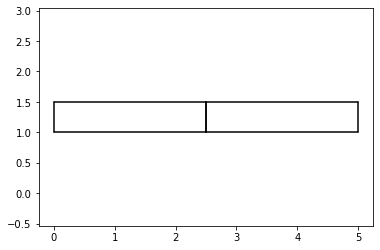

In [5]:
for g in geos:
    vis.plot_geo(g,grid=2)
axis('equal');

In [6]:
# rubber, Lamé-coeff.
Mu = 0.003 # [GPa]
Lam = 0.00028416 #  [GPa] (under ass. ny=0.48, almost incompressible)

In [7]:
def A11_vf(dim):
    from pyiga.vform import VForm, grad, inner, div, dx, Dx
    vf = VForm(dim)
    u, v = vf.basisfuns()
    
    grad_uv= inner(grad(u), grad(v))
    div_11 = Dx(u,0) * Dx(v,0)
    
    vf.add(Mu * ( grad_uv +  div_11) * dx  + Lam *div_11 * dx )
    return vf

def A12_vf(dim):
    from pyiga.vform import VForm, grad, inner, div, dx, Dx
    vf = VForm(dim)
    u, v = vf.basisfuns()

    grad_uv= inner(grad(u), grad(v))
    div_12 = Dx(u,1) * Dx(v,0)
    div_21 = Dx(u,0) * Dx(v,1)
    
    vf.add(Mu * div_21 * dx  + Lam *div_12 * dx )
    return vf

           
def A21_vf(dim):
    from pyiga.vform import VForm, grad, inner, div, dx, Dx
    vf = VForm(dim)
    u, v = vf.basisfuns()

    grad_uv= inner(grad(u), grad(v))
    div_12 = Dx(u,1) * Dx(v,0)
    div_21 = Dx(u,0) * Dx(v,1)
    
    vf.add( Mu * div_12 * dx  + Lam *div_21* dx )
    return vf
           
def A22_vf(dim):
    from pyiga.vform import VForm, grad, inner, div, dx, Dx
    vf = VForm(dim)
    u, v = vf.basisfuns()

    grad_uv= inner(grad(u), grad(v))
    div_22 = Dx(u,1) * Dx(v,1)
    
    vf.add(Mu * ( grad_uv +  div_22) * dx  + Lam *div_22 * dx)
    return vf


In [8]:
# source term f 
f = lambda x,y: (0.0) # source term

In [9]:
#Neumann BC
def g_N(x, y): return (-3e-7) # Neumann BC function

def g0(x,y):
    if (x>4).all():
        return -3e-7 # set force at distal end only
    else:
        return 0
    
def g(x,y):
    #print(x)
    if isinstance(x,numpy.float64):
        return (g0(x,y))
    #print (([g0(xi,0) for xi in np.nditer(x)]))
    return ([g0(xi,0) for xi in np.nditer(x)])


# set inhom. Neumann cond. on distal end, hom. NBC elsewhere
neu_data = [
  #  (0, 'top', g),
    (1, 'top', g) 
]

MP = assemble.Multipatch(patches, {'N':neu_data}, automatch=True)
#MP = assemble.Multipatch(patches, automatch=True) # without Neumann! 

In [10]:
#MP.shared_per_patch
#MP.shared_dofs
#print(MP.global_to_patch(1))

In [11]:
#A, rhs, N = MP.assemble_system(linelast_vf(2), vform.L2functional_vf(2, physical=True), f=f)

A11, rhs1, nbc11 = MP.assemble_system(A11_vf(2), vform.L2functional_vf(2, physical=True), f=f)
A12, rhs12, nbc12 = MP.assemble_system(A12_vf(2), vform.L2functional_vf(2, physical=True), f=f) 
A21, rhs21, nbc21 = MP.assemble_system(A21_vf(2), vform.L2functional_vf(2, physical=True), f=f) 
A22, rhs2, nbc22 = MP.assemble_system(A22_vf(2), vform.L2functional_vf(2, physical=True), f=f)

A = bmat([[A11, A12], [A21, A22]])

print(shape(A11))
print(shape(A))


(66, 66)
(132, 132)


In [12]:
rhs= np.hstack((rhs1, rhs2))
print(shape(rhs))

nbc= np.hstack((np.zeros(shape(nbc11)), nbc22)) ## in y-dir only

(132,)


In [13]:
# Dirichlet BC
# Dirichlet boundary function g
def g_zero(x, y): return (0.0) # scalar!

bcs = MP.compute_dirichlet_bcs([
    (0, 'left', g_zero)
])
print(shape(bcs))
#print(bcs)

bcs2= bcs[0]+MP.numdofs 
bcs12= np.append(bcs[0],bcs2)
bcs22 = np.append(bcs[1],bcs[1])

bc= [bcs12, bcs22]
#print(shape(bc))
#print(bc)


(2, 6)


In [14]:
# set up and solve linear system
LS = assemble.RestrictedLinearSystem(A, rhs +nbc, bc) #
u = LS.complete(solvers.make_solver(LS.A, spd=True).dot(LS.b))

#print(shape(u))
#print(u)


In [15]:
#print(MP.numdofs) # global dofs (=all dofs interface dofs,i.e. 2x16-4 = 28)
#print(2*MP.numdofs) 

u1 = u[:MP.numdofs]
u2 = u[MP.numdofs:2*MP.numdofs]

#print('u1= ',u1)
#print(shape(u1))
#print('u2= ', u2)
#print(shape(u2))

U = np.stack((u1,u2), axis=-1)
#print(U)
#print(shape(U))


In [16]:
N = tuple(kv.numdofs for kv in kvs)
print(N)
print(np.prod(N))
m_u = tuple(kv.numdofs for kv in kvs)
print (m_u)

num= np.prod(tuple(kv.numdofs for kv in kvs)) # inner dofs
print(num)

(6, 6)
36
(6, 6)
36


In [17]:
# restrict solution to each individual patch
u1_funcs = [geometry.BSplineFunc(kvs, MP.global_to_patch(p) @ u1)
           for p in range(len(patches))]
u2_funcs = [geometry.BSplineFunc(kvs, MP.global_to_patch(p) @ u2)
           for p in range(len(patches))]


In [18]:
def plot_grid(x,y, ax=None, **kwargs):
    ax = ax or plt.gca()
    segs1 = np.stack((x,y), axis=2)
    segs2 = segs1.transpose(1,0,2)
    ax.add_collection(LineCollection(segs1, **kwargs))
    ax.add_collection(LineCollection(segs2, **kwargs))
    ax.autoscale()
    

In [19]:
# evaluate displacement and "pressure" over a grid in the parameter domain
xgrid = linspace(0, 1, 10)
xygrid = (xgrid, xgrid)


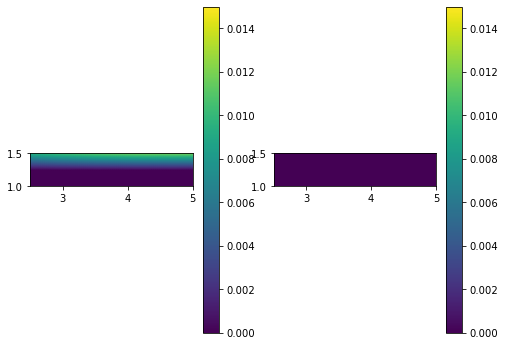

In [27]:
figsize(8,6)
fig, ax = plt.subplots()

for (u1_func,u2_func, (kvs, geo)) in zip(u1_funcs, u2_funcs, patches):
    #print(u_func)
    plt.subplot(1, 2, 1)
    
    vis.plot_field((u1_func), geo, vmin=0, vmax=1.5e-2)
    axis('scaled')
    colorbar();
    plt.subplot(1, 2, 2)

    vis.plot_field((u2_func), geo, vmin=0, vmax=1.5e-2)
    axis('scaled')
    colorbar();


(0.0, 5.011481556859403, 0.8389515565607912, 1.5)

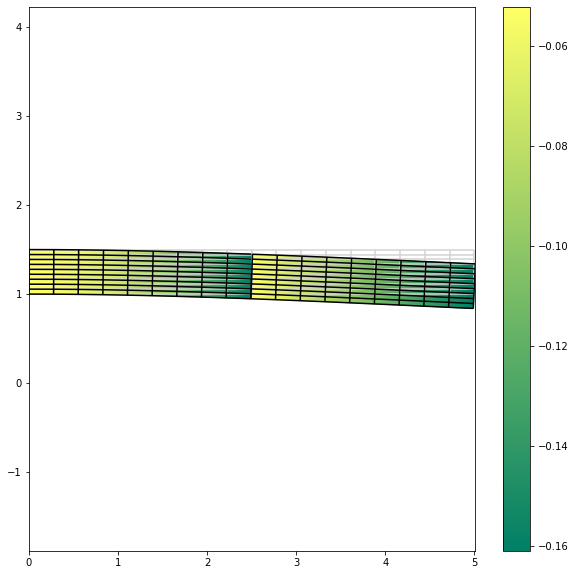

In [21]:
figsize(10,10)
fig, ax = plt.subplots()
i=0
d=[]
             
for (u1_func, u2_func, (kvs, geo)) in zip(u1_funcs, u2_funcs, patches): #u_funcs 
    #print(i)
    dis1= u1_func.grid_eval(xygrid)
    dis2 = u2_func.grid_eval(xygrid) 

    dis = np.stack((dis1,dis2), axis=-1)
    #print('dis=', dis)
    #print('dis1= ', dis1)
    #print(shape(dis1))
    #print('dis2= ', dis2)
    i+=1
    #d.append(dis)

    G = geo.grid_eval(xygrid)
    plot_grid(G[...,0], G[...,1], ax=ax, color="lightgrey")
    plot_grid(G[...,0]+dis1, G[...,1]+dis2,ax=ax, color="black")
    pcolormesh(G[...,0]+dis1, G[...,1]+dis2, dis2, cmap='summer', shading='gouraud');
    #pcolormesh(G[...,0]+dis[...,0], G[...,1]+dis[...,1], dis[...,0], cmap='summer', shading='gouraud');

#pcolormesh(G[...,0]+d[...,0], G[...,1]+d[...,1], d[...,1], cmap='summer', shading='gouraud');


    
#print(shape(d)) 
#print('d=', d)

#print(d[0][...,0]) #x values in 1st patch
#print(d[1][...,0]) #x values in 2nd patch
colorbar();
axis('equal')
